In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from tqdm import tqdm
import random

In [2]:
class Environment:

    def __init__(self, size: int, start: tuple, goal: tuple):
        # Map - 0 is obstacle, 1 is free space
        self.map = np.random.randint(0, 5, (size, size))
        self.map = np.where(self.map > 0, 1, 0) 

        # Start and Goal
        self.start = start
        self.goal = goal
        self.map[start] = 1
        self.map[goal] = 1
        
        # Action Space
        self.action_space = 4
        self.action_map = {
            0: "Up",
            1: "Down",
            2: "Left",
            3: "Right"
        }
    
    # Takes an action and returns the next state, reward
    def step(self, state: tuple, action: int):

        row, col = state

        if action == 0: # Up
            row = max(row - 1, 0)
        elif action == 1: # Down
            row = min(row + 1, self.map.shape[0] - 1)
        elif action == 2: # Left
            col = max(col - 1, 0)
        elif action == 3: # Right
            col = min(col + 1, self.map.shape[1] - 1)

        done = False
        new_state = (row, col)

        if new_state == self.goal:
            reward = 100
            done = True
        elif self.map[new_state] == 0: # Obstacle
            reward = -100
            new_state = state # Stay in the same state
        elif new_state == state:
            reward = -100 # Penalty for staying in the same state
        else:
            reward = -10
            
        return new_state, reward, done
    
    def visualize(self):
        plt.imshow(self.map, cmap='gray')
        plt.title('2D Tiled Map')
        plt.show()

In [3]:
class Agent:
    def __init__(self, env: Environment, gamma: float, alpha: float, epsilon: float):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        # Biased Q

        self.q_table = np.zeros((env.map.shape[0], env.map.shape[1], env.action_space))
        for i in range(env.map.shape[0]):
            for j in range(env.map.shape[1]):
                if env.map[i][j] == 0:

                    # Left cell
                    if j > 0 and env.map[i][j-1] == 1:
                        self.q_table[i][j-1][3] = -1000
                    # Right cell
                    if j < env.map.shape[1] - 1 and env.map[i][j+1] == 1:
                        self.q_table[i][j+1][2] = -1000
                    # Up cell
                    if i > 0 and env.map[i-1][j] == 1:
                        self.q_table[i-1][j][1] = -1000
                    # Down cell
                    if i < env.map.shape[0] - 1 and env.map[i+1][j] == 1:
                        self.q_table[i+1][j][0] = -1000

    # Epsilon Greedy Policy
    def choose_action(self, state: tuple):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.env.action_space)
        else:
            return np.argmax(self.q_table[state])
        
    # Q-Learning
    def update(self, state: tuple, action: int, reward: float, next_state: tuple):
        predict = self.q_table[state][action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.alpha * (target - predict)

    
    def train(self, episodes: int):

        for episode in tqdm(range(episodes), desc="Training Progress"):
            done = False
            steps = 0
            state = self.env.start

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(state, action)
                self.update(state, action, reward, next_state)
                state = next_state
                steps += 1

                # if steps > (self.env.map.shape[0] * self.env.map.shape[1]):
                #     break

        print('Training Completed!')

    def get_optimal_policy(self):
        policy = [[None for _ in range(self.env.map.shape[1])] for _ in range(self.env.map.shape[0])]
        for i in range(self.env.map.shape[0]):
            for j in range(self.env.map.shape[1]):
                max_indices = np.argwhere(self.q_table[i][j] == np.max(self.q_table[i][j])).flatten().tolist()
                policy[i][j] = max_indices
        return policy
    
    def visualize_optimal_policy(self):
        paths = []
        policy = self.get_optimal_policy()

        def backtrack(state, path):

            if len(paths) > 10:
                return

            if state == self.env.goal:
                paths.append(path.copy())
                return
            
            for action in policy[state[0]][state[1]]:
                next_state, _, _ = self.env.step(state, action)

                if next_state in path:
                    continue

                path.append(next_state)
                backtrack(next_state, path)
                path.pop()

        backtrack(self.env.start, [self.env.start])
        
        if len(paths) == 0:
            plt.title('No Optimal Path Found!')

        for idx, path in enumerate(paths):
            grid = 1 - self.env.map.copy()
            for i, j in path:
                grid[i][j] = 2

            plt.title(f'Optimal Path {idx+1}')
            plt.imshow(grid, cmap=plt.colormaps.get_cmap('Blues'))
            plt.show()

            if idx == 10:
                break

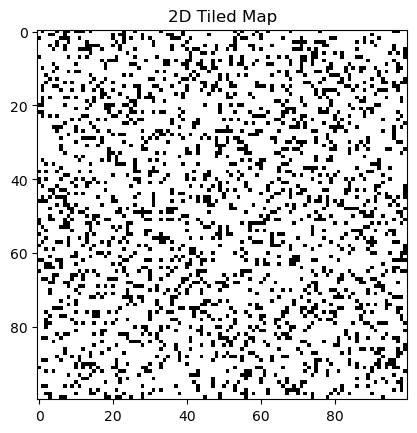

In [4]:
SIZE = 100

env = Environment(size=SIZE, start=(0, 0), goal=(SIZE-1, SIZE-1))
agent = Agent(env, gamma=0.9, alpha=0.1, epsilon=0.3)

# Visualize the environment
env.visualize()

In [5]:
agent.train(episodes=50000)

Training Progress: 100%|██████████| 50000/50000 [05:38<00:00, 147.66it/s]

Training Completed!


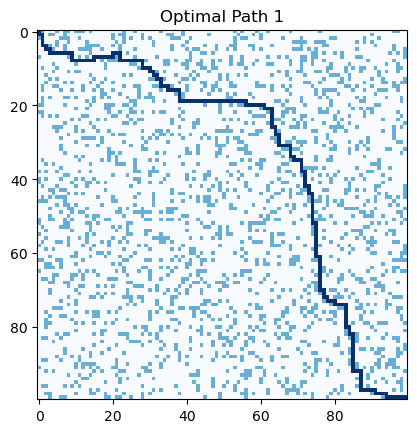

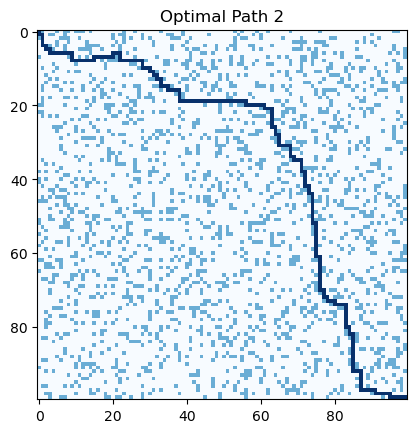

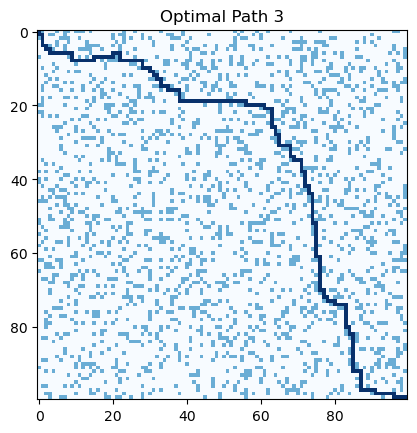

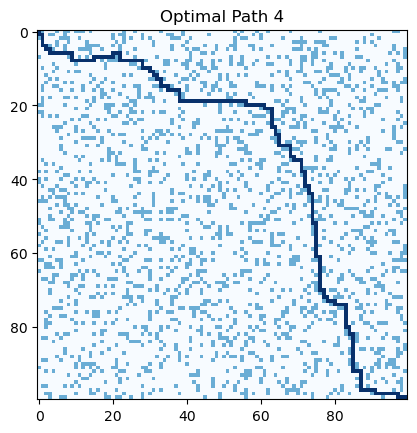

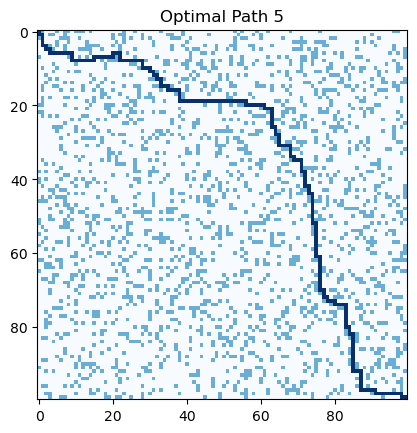

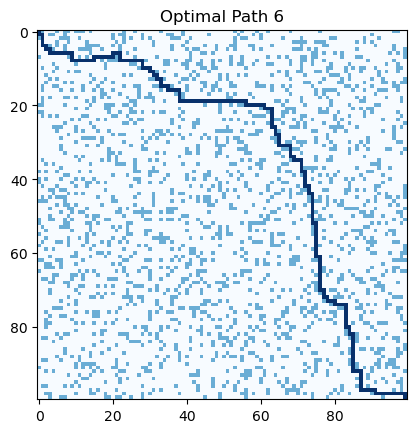

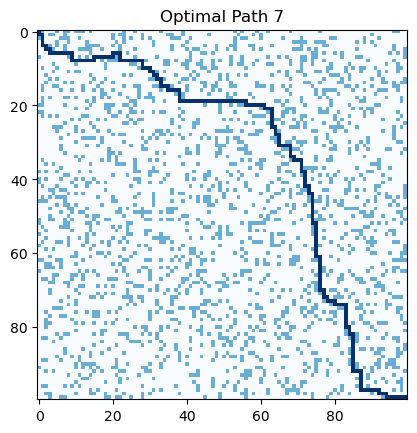

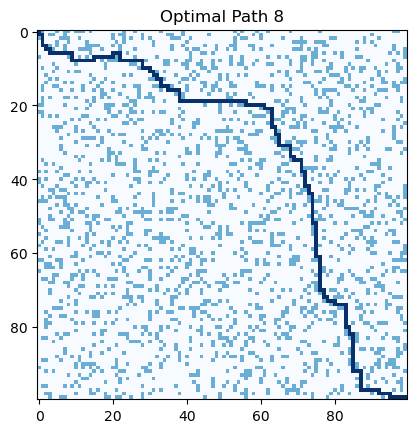

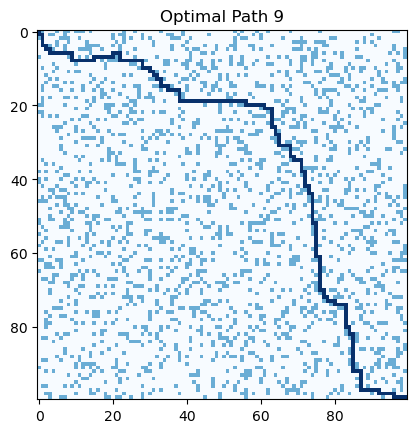

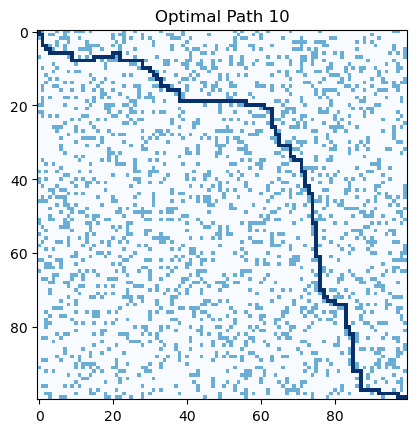

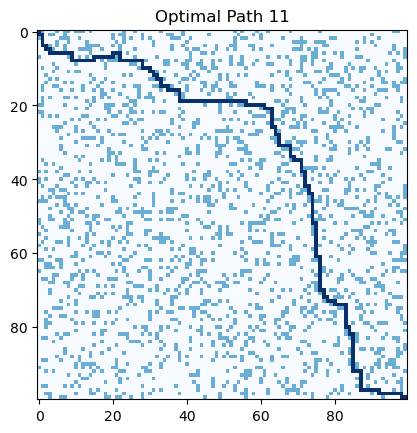

In [6]:
agent.visualize_optimal_policy()